## Abstract

In this paper, I reproduce aspects of *Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations* by Obermeyer et al. I find that Black people are rated at lower risk by an algorithim to help hospitals prioritize patient care than white people with the same number of chronic conditions. To understand why this is the case, I use a model to understand the role cost plays. I find that Black people spend around 75% of what white people spend for the same medical issues, which is why risk score is higher.

## Setup

In [4]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

pd.options.display.max_columns = None# Show all columns
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,dem_female,dem_age_band_18-24_tm1,dem_age_band_25-34_tm1,dem_age_band_35-44_tm1,dem_age_band_45-54_tm1,dem_age_band_55-64_tm1,dem_age_band_65-74_tm1,dem_age_band_75+_tm1,alcohol_elixhauser_tm1,anemia_elixhauser_tm1,arrhythmia_elixhauser_tm1,arthritis_elixhauser_tm1,bloodlossanemia_elixhauser_tm1,coagulopathy_elixhauser_tm1,compdiabetes_elixhauser_tm1,depression_elixhauser_tm1,drugabuse_elixhauser_tm1,electrolytes_elixhauser_tm1,hypertension_elixhauser_tm1,hypothyroid_elixhauser_tm1,liver_elixhauser_tm1,neurodegen_elixhauser_tm1,obesity_elixhauser_tm1,paralysis_elixhauser_tm1,psychosis_elixhauser_tm1,pulmcirc_elixhauser_tm1,pvd_elixhauser_tm1,renal_elixhauser_tm1,uncompdiabetes_elixhauser_tm1,valvulardz_elixhauser_tm1,wtloss_elixhauser_tm1,cerebrovasculardz_romano_tm1,chf_romano_tm1,dementia_romano_tm1,hemiplegia_romano_tm1,hivaids_romano_tm1,metastatic_romano_tm1,myocardialinfarct_romano_tm1,pulmonarydz_romano_tm1,tumor_romano_tm1,ulcer_romano_tm1,cost_dialysis_tm1,cost_emergency_tm1,cost_home_health_tm1,cost_ip_medical_tm1,cost_ip_surgical_tm1,cost_laboratory_tm1,cost_op_primary_care_tm1,cost_op_specialists_tm1,cost_op_surgery_tm1,cost_other_tm1,cost_pharmacy_tm1,cost_physical_therapy_tm1,cost_radiology_tm1,lasix_dose_count_tm1,lasix_min_daily_dose_tm1,lasix_mean_daily_dose_tm1,lasix_max_daily_dose_tm1,cre_tests_tm1,crp_tests_tm1,esr_tests_tm1,ghba1c_tests_tm1,hct_tests_tm1,ldl_tests_tm1,nt_bnp_tests_tm1,sodium_tests_tm1,trig_tests_tm1,cre_min-low_tm1,cre_min-high_tm1,cre_min-normal_tm1,cre_mean-low_tm1,cre_mean-high_tm1,cre_mean-normal_tm1,cre_max-low_tm1,cre_max-high_tm1,cre_max-normal_tm1,crp_min-low_tm1,crp_min-high_tm1,crp_min-normal_tm1,crp_mean-low_tm1,crp_mean-high_tm1,crp_mean-normal_tm1,crp_max-low_tm1,crp_max-high_tm1,crp_max-normal_tm1,esr_min-low_tm1,esr_min-high_tm1,esr_min-normal_tm1,esr_mean-low_tm1,esr_mean-high_tm1,esr_mean-normal_tm1,esr_max-low_tm1,esr_max-high_tm1,esr_max-normal_tm1,ghba1c_min-low_tm1,ghba1c_min-high_tm1,ghba1c_min-normal_tm1,ghba1c_mean-low_tm1,ghba1c_mean-high_tm1,ghba1c_mean-normal_tm1,ghba1c_max-low_tm1,ghba1c_max-high_tm1,ghba1c_max-normal_tm1,hct_min-low_tm1,hct_min-high_tm1,hct_min-normal_tm1,hct_mean-low_tm1,hct_mean-high_tm1,hct_mean-normal_tm1,hct_max-low_tm1,hct_max-high_tm1,hct_max-normal_tm1,ldl_min-low_tm1,ldl_min-high_tm1,ldl_min-normal_tm1,ldl-mean-low_tm1,ldl-mean-high_tm1,ldl-mean-normal_tm1,ldl_max-low_tm1,ldl_max-high_tm1,ldl_max-normal_tm1,nt_bnp_min-low_tm1,nt_bnp_min-high_tm1,nt_bnp_min-normal_tm1,nt_bnp_mean-low_tm1,nt_bnp_mean-high_tm1,nt_bnp_mean-normal_tm1,nt_bnp_max-low_tm1,nt_bnp_max-high_tm1,nt_bnp_max-normal_tm1,sodium_min-low_tm1,sodium_min-high_tm1,sodium_min-normal_tm1,sodium_mean-low_tm1,sodium_mean-high_tm1,sodium_mean-normal_tm1,sodium_max-low_tm1,sodium_max-high_tm1,sodium_max-normal_tm1,trig_min-low_tm1,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,90.0,380.0,640.0,3370.0,700.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,110.0,0.0,0.0,0.0,200.0,1480.0,2130.0,1940.0,6200.0,0.0,0.0,300.0,0,0,0.0,0,1,0,0,0,2,1,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,1,0,1,0,0,0,0,0,0,0,0,0

## Plot Re-Creation

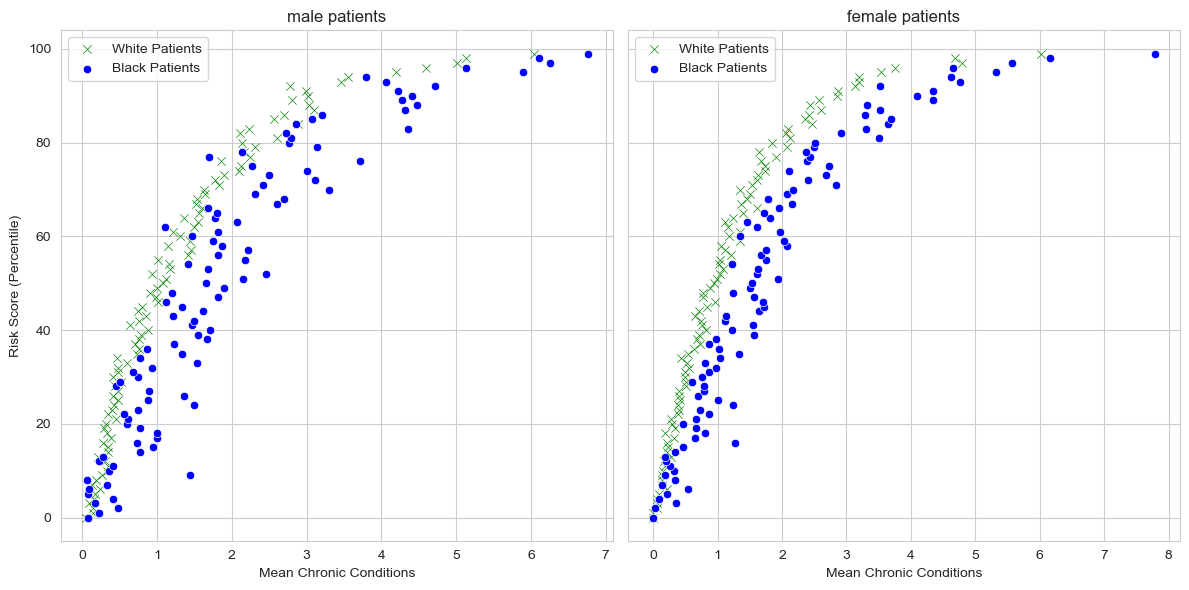

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df["percentile"] = pd.qcut(df['risk_score_t'], q=100, labels= False) #risk percentiles

markers = {"white": "x", "black": "o"} #markers for race
colors = {"white": "green", "black": "blue"}

sns.set_style("whitegrid")


fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

#looping through all people and sorting based on gender
for i, female in enumerate([0, 1]): #female = 1
    ax = axes[i]
    #loop through all races
    for race in df["race"].unique():
        subset = df[(df["dem_female"] == female) & (df["race"] == race)]
        grouped = subset.groupby("percentile")["gagne_sum_t"].mean().reset_index()
        sns.scatterplot(
            data=grouped, 
            x="gagne_sum_t", 
            y="percentile", 
            marker=markers[race], 
            color = colors[race],
            label=f"{race.capitalize()} Patients", 
            ax=ax
        )
    ax.set_title(f"{'female' if female == 1 else 'male'} patients")
    ax.set_xlabel("Mean Chronic Conditions")
    if i == 0:
        ax.set_ylabel("Risk Score (Percentile)")
    ax.legend()

plt.tight_layout()
plt.show()

Here we can see that white patients are more likely to be in a higher risk score percentile even if they have the same mean chronic conditions. We see the gap in between races widens as mean chronic conditions increase for both genders, espeically women. This means that there are other factors coming from ommited variable bias at play. These factors could be related to racism and the formula for calculating their risk score, which could include how much money patients are spending.

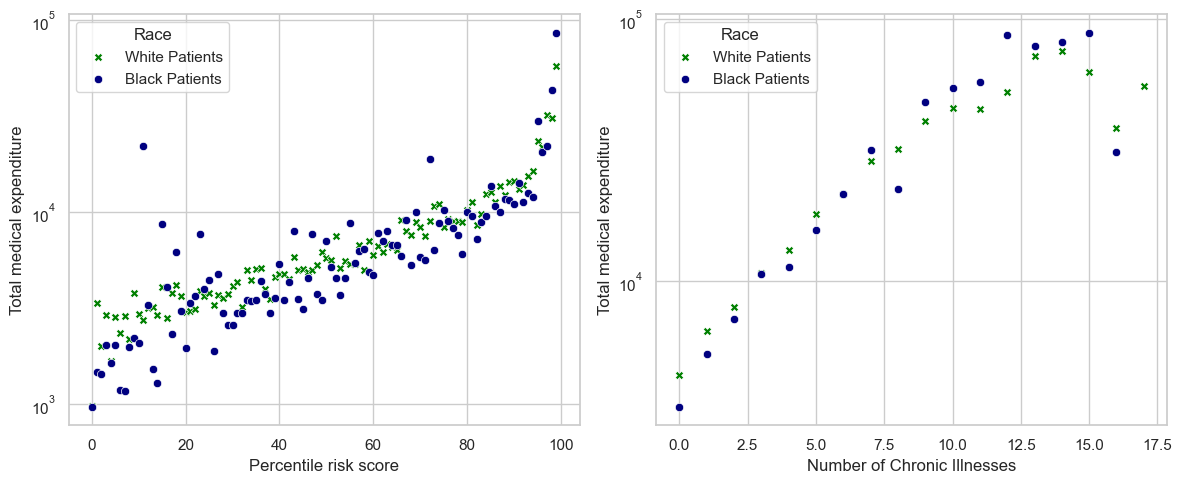

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

markers = {"black": "o", "white": "X"} #markers and colors for race
colors = {"black": "navy", "white": "green"}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, metric in enumerate(["percentile", "gagne_sum_t"]): #looping through each of the two plots
    ax = axes[i]

    for race in df["race"].unique(): #loop through races
        subset = df[df["race"] == race] #creating a subset of race for each race
        
        group = subset.groupby(metric)["cost_t"].mean().reset_index() #grouping for each race by metric

        sns.scatterplot(
            data=group,
            x=metric,
            y="cost_t",
            marker=markers[race],
            color=colors[race],
            label=f"{race.capitalize()} Patients",
            ax=ax
        )


    ax.set_yscale("log") #log scale
    ax.set_ylabel("Total medical expenditure")
    ax.set_xlabel("Percentile risk score" if metric == "percentile" else "Number of Chronic Illnesses")

    ax.legend(title="Race")

plt.tight_layout()
plt.show()


Now we are pulling in medical expenditure (on a logarithmic scale) into the equation. We can see that the average black person  at the same metric (risk percentile or chronic illnesses) spends less on medical expenses than the average white person. This is especially true as the percentile risk and the number of chronic conditions are normalized under a certian threshold.

## Data Prep

In [17]:
count = (df['gagne_sum_t'] <= 5).sum()
count/df.shape[0]

np.float64(0.9553952115447688)

95% of people have 5 or less chronic conditions, so it makes sense to just focus on these people to get a better sense of the true population we want to cover.

In [21]:
df_cost = df[df["cost_t"] != 0] # creating a dataframe where costs aren't equal to 0
df_cost["log_cost"]= np.log(df["cost_t"]) #taking log of costs

/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/gx/d6zl9l4908q7p_vk4j3x06x00000gn/T/ipykernel_40052/212932897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cost["log_cost"]= np.log(df["cost_t"])


In [33]:
df_cost["race_d"]= df["race"].map({"white": 0, "black": 1}) #creating a binary variable for race

/var/folders/gx/d6zl9l4908q7p_vk4j3x06x00000gn/T/ipykernel_40052/3074851344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cost["race_d"]= df["race"].map({"white": 0, "black": 1})


## Model

In [ ]:
#setting up modeling dataframes
X= df_cost[["race_d", "gagne_sum_t"]] 
y= df_cost["log_cost"]

In [35]:
def add_polynomial_features(X, degree): #adding polynomial features function
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

In [66]:
from sklearn.linear_model import Ridge
k = [-4, -3, -2, -1, 0, 1, 2, 3, 4] #regularization stenghts

In [74]:
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import cross_val_score
best_score= 0
result= []
for i in k: # looping through regularization strengths
    for j in range(1, 11): #looping through polynomial degrees
        alpha = 10 ** k[i]
        newX= add_polynomial_features(X, j) #adding polynomial features to x
        LR = Ridge(alpha = alpha) 
        score_p = cross_val_score(LR, newX, y, cv = 5, scoring='neg_mean_squared_error').mean() # calculating the score by the mean of the squared error
        score= -score_p #negating the score
        result.append({"reg_strength_coef": i, 
                        "reg_strength": alpha,
                        "degree" : j,
                        "mse": score}) #storing the results

df_result = pd.DataFrame(result) # creating a df from the results
df_result = df_result.sort_values("mse") # sorting by mean squared error
best = round(df_result.iloc[0],2) #pulling out the highest values
best




reg_strength_coef     4.00
reg_strength          1.00
degree               10.00
mse                   1.51
Name: 89, dtype: float64

In [90]:
model = Ridge(alpha = 1) #optimal alpha = 1
X_ft= add_polynomial_features(X, 10) #optimal features = 10
model.fit(X_ft, y) #fit the model
coef_idx = list(X_ft.columns).index("race_d") #getting index of the coefficents for race
race_coef = model.coef_[coef_idx] # pulling out specific coefficent
print("Black Coefficent: ", race_coef)

race_coef_exp = np.exp(race_coef) #getting %
print("Black percent of spend: ", race_coef_exp)

Black Coefficent:  -0.26704550927753734
Black percent of spend:  0.7656382270299403


Black people only spend 77% of what White people do for the same medical problems. This is in line with Obermeyer et al. (2019), as they presented the same research, Black people's risk is weighted less than white people's because of disparities in historic spending, coming from systemic problems.

## Discussion

From this analysis, we find that the racial disparity in risk scores stems back to racial disparity in medical costs, which come from systemic racism. This is why the risk score is a flawed and biased measure. The bias is best described by disparate impact, as discussed in Chapter 3 of Fairness and Machine Learning. The algorithm used healthcare costs as a proxy for health, but because Black patients historically receive less medical spending due to systemic racism, the model underestimated their health needs. This led to Black patients being less likely to receive the same level of care recommendations as white patients, even though they were equally sick. The study supports this by showing that at the same risk score, Black patients had worse health outcomes, proving that cost was a flawed proxy. 